In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn
pd.set_option('use_inf_as_na', True)
from collections import Counter

In [3]:
raw_data = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [4]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
    
        return 0

In [5]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [6]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

## Long term performance with Random Forest Classifier, optimal hyper-parameters

In [19]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [20]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 6):d+pd.DateOffset(months = 9)] for d in end_dates]

In [21]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [22]:
valid_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in valid_frames]

In [23]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [24]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [12]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])
        
    

In [14]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

In [190]:
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    rf_n_estimators = trial.suggest_int('n_estimators', 10,40,step=5)
    rf_max_features = trial.suggest_categorical('max_features',['sqrt','log2'])
    rf_min_samples_leaf = trial.suggest_int('min_samples_leaf',400,2400,step=400)
    rf_max_depth = trial.suggest_int('max_depth',5,25,step=5)
    
    rf_clf = RandomForestClassifier(n_estimators=rf_n_estimators,
                                    max_depth=rf_max_depth,
                                    min_samples_leaf=rf_min_samples_leaf,
                                    max_features=rf_max_features)
    rf_clf.fit(train,labels)
    preds = rf_clf.predict(val)
    profit = (preds * val_rets).sum()
 
    return profit

In [15]:
optimal_hyperparameters = []

In [16]:
from functools import partial

In [193]:
for i in range(len(start_dates)-1):
    
    study = optuna.create_study(direction="maximize")
    
    study.optimize(partial(objective,
                           train=training_data[i],
                           labels=training_labels[i],
                           val=valid_data[i],
                           val_labels=valid_labels,
                           val_rets=valid_frames[i]['next_period_return']), n_trials=200,n_jobs=-1)
    
    optimal_hyperparameters.append(study.best_params)  
    print(study.best_params)
    

{'n_estimators': 20, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 5}
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 10}
{'n_estimators': 35, 'max_features': 'sqrt', 'min_samples_leaf': 800, 'max_depth': 15}
{'n_estimators': 15, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 15}
{'n_estimators': 15, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 15}
{'n_estimators': 10, 'max_features': 'log2', 'min_samples_leaf': 1600, 'max_depth': 10}
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 25}
{'n_estimators': 30, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 25}
{'n_estimators': 20, 'max_features': 'log2', 'min_samples_leaf': 1200, 'max_depth': 15}
{'n_estimators': 10, 'max_features': 'sqrt', 'min_samples_leaf': 400, 'max_depth': 25}
{'n_estimators': 10, 'max_features': 'log2', 'min_samples_leaf': 2400, 'max_depth': 5}
{'n_estimators': 25, 'max_features': 'log2

In [10]:
import pickle

In [194]:
with open(r'optimal_hyperparameters_01.pkl','wb') as f:
    pickle.dump(optimal_hyperparameters,f)

In [18]:
with open(r'optimal_hyperparameters.pkl','rb') as f:
    optimal_hyperparameters = pickle.load(f)

In [19]:
optimal_hyperparameters

[{'n_estimators': 30,
  'max_features': 'log2',
  'min_samples_leaf': 1600,
  'max_depth': 15},
 {'n_estimators': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 20},
 {'n_estimators': 10,
  'max_features': 'log2',
  'min_samples_leaf': 800,
  'max_depth': 25},
 {'n_estimators': 30,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 15},
 {'n_estimators': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 15},
 {'n_estimators': 10,
  'max_features': 'log2',
  'min_samples_leaf': 2000,
  'max_depth': 20},
 {'n_estimators': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 800,
  'max_depth': 10},
 {'n_estimators': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 2400,
  'max_depth': 25},
 {'n_estimators': 15,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 10},
 {'n_estimators': 30,
  'max_features': 'sqrt',
  'min_samples_leaf': 400,
  'max_depth': 25},
 {'n_estimators': 15,
  'max_features': 'log2',

In [15]:
classifiers = []

In [21]:
for hyp_par in optimal_hyperparameters:
    rf_clf = RandomForestClassifier(**hyp_par)
    classifiers.append(rf_clf)

In [22]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(training_data[i],training_labels[i])

In [245]:
with open(r'classifiers.pkl','wb') as f:
    pickle.dump(classifiers,f)

In [16]:
with open(r'classifiers.pkl','rb') as f:
    classifiers = pickle.load(f)

In [24]:
def randomforest_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [25]:
significant_features = []

In [201]:
for i in range(len(start_dates)-1): 
    fi = randomforest_feat_importances(classifiers[i],training_data[i])
    features = fi[(fi['feat_imp'] > 0.00)]['cols'].values
    significant_features.append(features)

In [24]:
significant_features

[array(['rectq', 'apq', 'equity_invcapq', 'curr_ratioq', 'oeps12',
        'ibcomq', 'oepsxq', 'epsfiq', 'fcf_csfhdq', 'opepsq', 'market_cap',
        'lctq', 'dvpspq', 'pe_op_basicq', 'cash_ratioq', 'debt_atq',
        'cf_yield', 'epsfi12', 'atq', 'oepsxy', 'pe_op_dilq', 'rect_actq',
        'lagbe4', 'ltq', 'yearly_sales', 'dvy', 'csh12q', 'actq', 'revty',
        'prccq', 'invtq', 'quick_ratioq', 'cheq', 'roeq', 'xinty', 'at4',
        'lt_debtq', 'book_value_yield', 'cfo-per-share', 'capxq', 'cshprq',
        'ibcq', 'niq', 'lagseq4', 'dlttq', 'lagppent_alt4', 'mibq',
        'dltisy', 'cfmq', 'txditcq', 'ibcomy'], dtype=object),
 array(['cfmq', 'epspi12', 'oeps12', 'oepf12', 'saleq', 'epsfi12',
        'curr_ratioq', 'pe_op_dilq', 'ptpmq', 'csh12q', 'market_cap',
        'dvpspq', 'cfo-per-share', 'capeiq', 'fcf_yield', 'pe_incq',
        'fcf_csfhdq', 'req', 'rectq', 'yearly_sales', 'oancfy',
        'pay_turnq', 'lagicapt4', 'oancfy_q', 'prccq', 'lagppent_alt4',
        'pretre

In [203]:
with open(r'significant_features_01.pkl','wb') as f:
    pickle.dump(significant_features,f)

In [27]:
with open(r'significant_features.pkl','rb') as f:
    significant_features = pickle.load(f)

In [28]:
new_training_data = []
new_valid_data = []
new_test_data = []

In [29]:
for i in range(len(start_dates)-1): 
    new_training_data.append(training_data[i][significant_features[i]])
    new_valid_data.append(valid_data[i][significant_features[i]])
    new_test_data.append(test_data[i][significant_features[i]])
    

In [30]:
new_valid_data[1].columns

Index(['cfmq', 'epspi12', 'oeps12', 'oepf12', 'saleq', 'epsfi12',
       'curr_ratioq', 'pe_op_dilq', 'ptpmq', 'csh12q', 'market_cap', 'dvpspq',
       'cfo-per-share', 'capeiq', 'fcf_yield', 'pe_incq', 'fcf_csfhdq', 'req',
       'rectq', 'yearly_sales', 'oancfy', 'pay_turnq', 'lagicapt4', 'oancfy_q',
       'prccq', 'lagppent_alt4', 'pretret_noaq', 'rd_saleq', 'sale_nwcq',
       'cshfdq', 'be4', 'opepsq', 'lctq', 'book_value_yield', 'cogsq',
       'pe_op_basicq', 'beq', 'debt_assetsq', 'curr_debtq', 'xrdq', 'apq',
       'roeq', 'cshprq', 'profit_lctq', 'at_turnq', 'cf_yield', 'dprq', 'ibcq',
       'xsgay', 'txpdy', 'txpq', 'atq', 'quick_ratioq', 'pe_exiq', 'dpcq',
       'de_ratioq', 'intcov_ratioq', 'xidoy', 'epsx12', 'roceq', 'actq',
       'sale_invcapq', 'sic_6020', 'dvy', 'icaptq', 'cash_debtq', 'cash_ltq',
       'seq4', 'fqtr_4', 'dvq', 'epspxq', 'niq', 'oibdpy', 'ibadj12', 'pcfq',
       'inv_turnq', 'psq', 'dltry', 'opmadq', 'accrualq', 'ibq', 'at5',
       'cshiq'],
   

In [30]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in new_training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    new_training_data[i] = new_training_data[i].copy()
    new_valid_data[i] = new_valid_data[i].copy()
    new_test_data[i] = new_test_data[i].copy()
    new_training_data[i][float_vars] = scaler.fit_transform(new_training_data[i][float_vars])
    new_valid_data[i][float_vars] = scaler.transform(new_valid_data[i][float_vars])
    new_test_data[i][float_vars] = scaler.transform(new_test_data[i][float_vars])

In [31]:
for i in range(len(start_dates)-1): 
    classifiers[i].fit(new_training_data[i],training_labels[i])

In [32]:
with open(r'classifiers.pkl','wb') as f:
    pickle.dump(classifiers,f)

In [33]:
with open(r'classifiers.pkl','rb') as f:
    classifiers = pickle.load(f)

In [34]:
def model(features):
    tree_features = features[features.columns[:-1].values]

    pred = rf_clf.predict(tree_features)

    ret = pred * features[features.columns[-1]]

    return ret

In [35]:
import shap

In [36]:
shap_features = []

In [37]:
for i in range(len(start_dates)-1):
    valid_1 = new_valid_data[i].copy()
    cols = new_valid_data[i].columns
    print(len(cols))
    valid_1['rets'] = valid_frames[i]['next_period_return'].values
    rf_clf = classifiers[i]
    explainer = shap.explainers.Permutation(model,valid_1)
    shap_values = explainer(valid_1,max_evals=1000,)
    shap_cols = cols[np.abs(shap_values[:,:-1].values).mean(axis=0)>0.000]
    if shap_cols.empty:
        shap_cols = cols[:10]
    print(len(shap_cols))
    shap_features.append(shap_cols)
    

51


Permutation explainer: 1123it [05:02,  3.60it/s]                                                                       


15
83


Permutation explainer: 1156it [03:23,  5.40it/s]                                                                       


41
41


Permutation explainer: 1174it [03:01,  6.08it/s]                                                                       


10
150


Permutation explainer: 1137it [07:48,  2.38it/s]                                                                       


106
125


Permutation explainer: 1266it [05:38,  3.64it/s]                                                                       


84
17


Permutation explainer: 1261it [03:34,  5.61it/s]                                                                       


10
49


Permutation explainer: 1256it [03:13,  6.11it/s]                                                                       


10
15


Permutation explainer: 1284it [04:03,  5.03it/s]                                                                       


14
125


Permutation explainer: 1316it [05:10,  4.09it/s]                                                                       


49
147


Permutation explainer: 1414it [09:54,  2.34it/s]                                                                       


41
20


Permutation explainer: 1361it [04:39,  4.69it/s]                                                                       


18
149


Permutation explainer: 1355it [09:25,  2.35it/s]                                                                       


129
155


Permutation explainer: 1475it [11:40,  2.08it/s]                                                                       


142
105


Permutation explainer: 1512it [05:21,  4.53it/s]                                                                       


87
152


Permutation explainer: 1523it [09:07,  2.73it/s]                                                                       


130
113


Permutation explainer: 1499it [05:46,  4.22it/s]                                                                       


90
140


Permutation explainer: 1455it [10:49,  2.21it/s]                                                                       


115
110


Permutation explainer: 1400it [05:05,  4.42it/s]                                                                       


90
115


Permutation explainer: 1376it [05:29,  4.04it/s]                                                                       


83
117


Permutation explainer: 1301it [05:17,  3.95it/s]                                                                       


89
94


Permutation explainer: 1099it [06:26,  2.77it/s]                                                                       


72
107


Permutation explainer: 1029it [05:40,  2.92it/s]                                                                       


67
44


Permutation explainer: 1180it [04:24,  4.29it/s]                                                                       


10
59


Permutation explainer: 1279it [04:22,  4.68it/s]                                                                       


32
83


Permutation explainer: 1353it [04:44,  4.56it/s]                                                                       


54
28


Permutation explainer: 1442it [03:47,  6.09it/s]                                                                       


10
132


Permutation explainer: 1388it [05:52,  3.83it/s]                                                                       


96
19


Permutation explainer: 1443it [03:58,  5.81it/s]                                                                       


10
48


Permutation explainer: 1554it [05:52,  4.28it/s]                                                                       


10
24


Permutation explainer: 1547it [03:57,  6.20it/s]                                                                       


10
128


Permutation explainer: 1612it [06:31,  4.01it/s]                                                                       


105
29


Permutation explainer: 1426it [03:39,  6.24it/s]                                                                       


10
163


Permutation explainer: 1528it [10:35,  2.37it/s]                                                                       


120
117


Permutation explainer: 1610it [06:13,  4.21it/s]                                                                       


93
116


Permutation explainer: 1619it [06:07,  4.28it/s]                                                                       


92
121


Permutation explainer: 1531it [08:58,  2.79it/s]                                                                       


87
118


Permutation explainer: 1625it [07:26,  3.56it/s]                                                                       


104
106


Permutation explainer: 1751it [09:10,  3.11it/s]                                                                       


65
38


Permutation explainer: 1802it [04:30,  6.46it/s]                                                                       


21
84


Permutation explainer: 1875it [05:21,  5.63it/s]                                                                       


64
55


Permutation explainer: 1957it [04:54,  6.45it/s]                                                                       


37
149


Permutation explainer: 1969it [15:15,  2.13it/s]                                                                       


136
156


Permutation explainer: 2061it [12:09,  2.79it/s]                                                                       


139
102


Permutation explainer: 1973it [06:06,  5.24it/s]                                                                       


74
30


Permutation explainer: 2042it [05:00,  6.56it/s]                                                                       


18
129


Permutation explainer: 2081it [07:21,  4.60it/s]                                                                       


106
134


Permutation explainer: 2136it [08:17,  4.20it/s]                                                                       


108
126


Permutation explainer: 1949it [07:05,  4.46it/s]                                                                       


103
74


Permutation explainer: 1965it [10:51,  2.97it/s]                                                                       


42
105


Permutation explainer: 1951it [12:14,  2.62it/s]                                                                       


76
83


Permutation explainer: 2006it [06:06,  5.31it/s]                                                                       


64
84


Permutation explainer: 2006it [10:08,  3.24it/s]                                                                       


60
136


Permutation explainer: 2067it [08:08,  4.14it/s]                                                                       


111
164


Permutation explainer: 2109it [18:31,  1.88it/s]                                                                       


158
63


Permutation explainer: 2155it [08:53,  3.97it/s]                                                                       


37
175


Permutation explainer: 2155it [17:12,  2.06it/s]                                                                       

174


In [38]:
with open(r'shap_features_01.pkl','wb') as f:
    pickle.dump(shap_features,f)

In [39]:
with open(r'shap_features.pkl','rb') as f:
    shap_features = pickle.load(f)

In [46]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 39) for d in start_dates]

In [47]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 39)] for d in start_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [48]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [49]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features[i]].values),columns=shap_features[i]) for i in range(len(start_dates)-1)]

In [217]:
opt_test_data[1]

,quick_ratioq,fcf_csfhdq,pcfq,xsgay,evmq,fcf_yield,oepf12,cf_yield,dvpspq,oeps12,...,opcfq,capeiq,actq,nopiq,cshoq,epspiq,intcovq,cash_ltq,piq,epsfiq
0,0.943761,-0.217266,0.122199,-0.267934,0.079080,-0.198007,-0.034950,-0.642707,-0.609345,-0.034056,...,-0.251530,0.007903,-0.182217,0.050709,-0.186967,0.024099,0.004608,2.266002,-0.127235,0.021062
1,-0.086185,-0.356346,-0.035955,-0.337319,-1.008394,-0.406912,-0.148162,2.737811,-0.416958,-0.151559,...,0.419426,0.008470,1.396938,0.955536,0.368063,-0.397836,0.005611,-0.323813,-0.490005,-0.398602
2,-0.317386,-0.111938,-0.011194,0.345250,0.015285,-0.016963,-0.008932,-0.108673,-0.200524,-0.011540,...,-0.179077,0.017206,-0.159999,0.027119,-0.212314,-0.040432,0.004608,-0.118076,-0.134250,-0.034556
3,-0.232305,0.049499,0.007315,-0.198088,0.013118,0.051241,0.069825,-0.203505,-0.609345,0.077115,...,-0.200667,0.027228,0.044884,0.027669,-0.286651,0.197838,0.009246,-0.356163,-0.046697,0.187917
4,-0.164772,0.098515,-0.033265,3.390534,0.019836,0.009106,0.048026,-0.334669,0.496878,0.048971,...,1.090416,0.019878,1.279020,0.472100,1.685134,0.237549,0.042413,-0.244303,2.158498,0.238479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,-0.240716,-0.144245,-0.025578,0.083521,-0.004318,-0.058058,-0.015964,-0.278956,0.641168,-0.019983,...,-0.031139,0.017299,0.696185,0.062553,0.221718,0.068775,0.009303,-0.325713,0.211921,0.071624
1132,-0.246900,0.077786,0.162820,-0.263041,0.016386,-0.032305,0.032556,-0.387362,-0.416958,0.034899,...,-0.263126,0.016968,-0.378984,0.023169,-0.372983,0.138270,0.004608,-0.272076,-0.173443,0.137355
1133,0.176708,-0.307842,-0.033820,-0.211596,0.004571,-0.232850,-0.084172,0.400038,-0.609345,-0.084716,...,0.071823,0.007877,0.125469,0.039205,0.343712,-0.045396,0.018186,0.032240,0.016430,-0.044668
1134,0.439776,0.014379,0.356613,-0.308801,0.017270,-0.028351,0.009351,-0.453907,-0.609345,0.013790,...,-0.281381,0.014460,-0.395252,0.028248,-0.391962,0.168054,0.004608,0.356833,-0.192321,0.152523


In [50]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

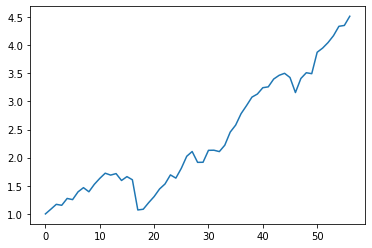

In [51]:
plt.plot(x);

In [34]:
len(x)

57

In [52]:
SPY = pd.read_pickle(r'C:\Users\niels\OneDrive\Machine Learning 2022\Lecture 2\SPY_cum_ret.pkl')
SPY = SPY.loc['2004-07-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

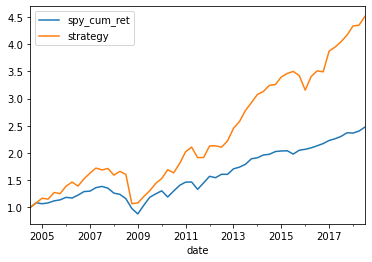

In [53]:
SPY.plot();

In [54]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.4595911370055951


In [74]:
 (SPY['strategy'] - 1).diff().std()

0.20918527132649586

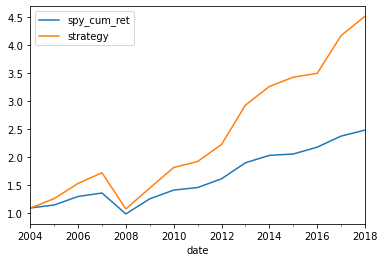

In [55]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [56]:
with open(r'rf strategy.pkl','wb') as f:
    pickle.dump(SPY['strategy'].values,f)

In [57]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  0.7721756327053821


In [58]:
x[-1]

4.512783573171325

In [59]:
SPY['spy_cum_ret'][-1]

2.4779340000000003

In [60]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [61]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]

In [62]:
beta 

2.02217001480749

In [63]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
print('beta: ',beta)
residual_ret = strategy_ret - beta * spy_ret
IR = np.mean(residual_ret)/np.std(residual_ret)
print('Information Ratio: ',IR)

beta:  2.02217001480749
Information Ratio:  0.38433237994371644


In [64]:
alpha = np.mean(residual_ret)

In [65]:
alpha

0.044056293343408846